# Imports

In [1]:
import sys
sys.path.insert(1, '../..')

import convml_tt
from utils import *

from convml_tt.system import TripletTrainerModel, TripletTrainerDataModule
from convml_tt.data.examples import fetch_example_dataset, ExampleData, fetch_pretrained_model, PretrainedModel
from convml_tt.data.dataset import TileType, ImageSingletDataset
from convml_tt.utils import get_embeddings
import convml_tt.interpretation
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import xarray as xr
import pandas as pd
import pytorch_lightning as pl
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import torch
from sklearn.decomposition import PCA
from PIL import Image
import os, shutil
from matplotlib.patches import Rectangle as rectan
from random import seed
from random import randint
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from tqdm.notebook import tqdm


from convml_tt.interpretation.rectpred.transform import apply_transform
from convml_tt.data.examples import load_pretrained_model, PretrainedModel
from convml_tt.interpretation.rectpred.data import make_sliding_tile_model_predictions
from convml_tt.interpretation.rectpred.plot import make_rgb


TILE_FILENAME_FORMAT = "{triplet_id:05d}_{tile_type}.png"
TEST_SIZE = 0.3
RANDOM_STATE = 1024
COLORS = ['b', 'g', 'r', 'm'] # Color of each class
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
#DATASET_DIR = "../../../NC/zooniverse/"
DATASETS_path = "/home/fbrient/Dropbox/Documents/EUREC4A/Data/"
DATASET_DIR   = DATASETS_path+"Kaggle/"
print(cv2.__version__)
print(np.__version__)
pca = PCA(n_components=3, svd_solver='arpack')

4.5.3
4.5.3
1.20.1


## Reading Leif Model

In [2]:
model_path = fetch_pretrained_model(pretrained_model=PretrainedModel.FIXED_NORM_STAGE2, data_dir="../../")
#model = TripletTrainerModel.load_from_checkpoint(checkpoint_path="c:/Users/Ray/Documents/Stage/MODELS/checkpt")
model = TripletTrainerModel.load_from_checkpoint(checkpoint_path="/home/fbrient/Dropbox/Documents/Stages/2021/IA/Internship_files/models/Tile2Vec/zooniverse-model.ckpt")
print(PretrainedModel.FIXED_NORM_STAGE2)
print(model_path)
print(model)

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using downloaded and verified file: ../../fixednorm-stage-2.tgz
Extracting ../../fixednorm-stage-2.tgz to ../../
PretrainedModel.FIXED_NORM_STAGE2
../../fixednorm-stage-2.torch.pkl
TripletTrainerModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (1): BlurPool(
        (pad): ReflectionPad2d((1, 2, 1, 2))
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

## Reading Zooniverse dataset downloaded from : https://www.kaggle.com/c/understanding_cloud_organization/data

In [4]:
#df = pd.read_csv("../../../NC/zooniverse/train.csv")
df = pd.read_csv(DATASET_DIR+"train.csv")
print(DATASET_DIR+"train.csv")

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train.csv


In [5]:
print(df)

              Image_Label                                      EncodedPixels
0        0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1      0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2      0011165.jpg_Gravel                                                NaN
3       0011165.jpg_Sugar                                                NaN
4        002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...
...                   ...                                                ...
22179   ffd6680.jpg_Sugar                                                NaN
22180    ffea4f4.jpg_Fish                                                NaN
22181  ffea4f4.jpg_Flower  1194860 675 1196260 675 1197660 675 1199060 67...
22182  ffea4f4.jpg_Gravel                                                NaN
22183   ffea4f4.jpg_Sugar                                                NaN

[22184 rows x 2 columns]


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preparing different columns of dataframe

In [6]:
df['Image'] = df['Image_Label'].map(lambda x: x.split('_')[0])
df['Class'] = df['Image_Label'].map(lambda x: x.split('_')[1])
classes = df['Class'].unique()
train_df = df.groupby('Image')['Class'].agg(set).reset_index()
print(train_df)
for class_name in classes:
    df[class_name] = df['Class'].map(lambda x: 1 if class_name in x else 0)
df.head()

            Image                          Class
0     0011165.jpg  {Gravel, Fish, Flower, Sugar}
1     002be4f.jpg  {Gravel, Fish, Flower, Sugar}
2     0031ae9.jpg  {Gravel, Fish, Flower, Sugar}
3     0035239.jpg  {Gravel, Fish, Flower, Sugar}
4     003994e.jpg  {Gravel, Fish, Flower, Sugar}
...           ...                            ...
5541  ffcedf2.jpg  {Gravel, Fish, Flower, Sugar}
5542  ffd11b6.jpg  {Gravel, Fish, Flower, Sugar}
5543  ffd3dfb.jpg  {Gravel, Fish, Flower, Sugar}
5544  ffd6680.jpg  {Gravel, Fish, Flower, Sugar}
5545  ffea4f4.jpg  {Gravel, Fish, Flower, Sugar}

[5546 rows x 2 columns]


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         Image   Class  Fish  Flower  Gravel  Sugar  
0  0011165.jpg    Fish     1       0       0      0  
1  0011165.jpg  Flower     0       1       0      0  
2  0011165.jpg  Gravel     0       0       1      0  
3  0011165.jpg   Sugar     0       0       0      1  
4  002be4f.jpg    Fish     1       0       0      0

## Preparing functions to extract masks of bounding boxes

In [7]:
# Creating training samples

image_col = np.array(df['Image'])
image_files = image_col[::4]
#print(type(image_files))
#print(type(np.unique(image_col)))
all_labels = df['Class']
#print(all_labels)
X_train, y_train = image_files, all_labels
train_pairs = np.array(list(zip(X_train, y_train)))
print(train_pairs.shape)
#TILE_FILENAME_FORMAT = "{triplet_id:05d}_{tile_type}.png"
NUM_TRAIN_SAMPLES = len(train_pairs)
train_samples = train_pairs[np.random.choice(train_pairs.shape[0], NUM_TRAIN_SAMPLES, replace=False), :]
print(train_pairs)

(5546, 2)
[['0011165.jpg' 'Fish']
 ['002be4f.jpg' 'Flower']
 ['0031ae9.jpg' 'Gravel']
 ...
 ['ffd3dfb.jpg' 'Sugar']
 ['ffd6680.jpg' 'Fish']
 ['ffea4f4.jpg' 'Flower']]


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Creating training tile dataset

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5546 [00:00<?, ?it/s]

<ipython-input-32-0c74fb114ea6>:61: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_title('{} - ({})'.format(sample[0], ', '.join(sample[1].astype(np.str))))


/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a19c44a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00000_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00001_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00002_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00003_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00004_anchor.png


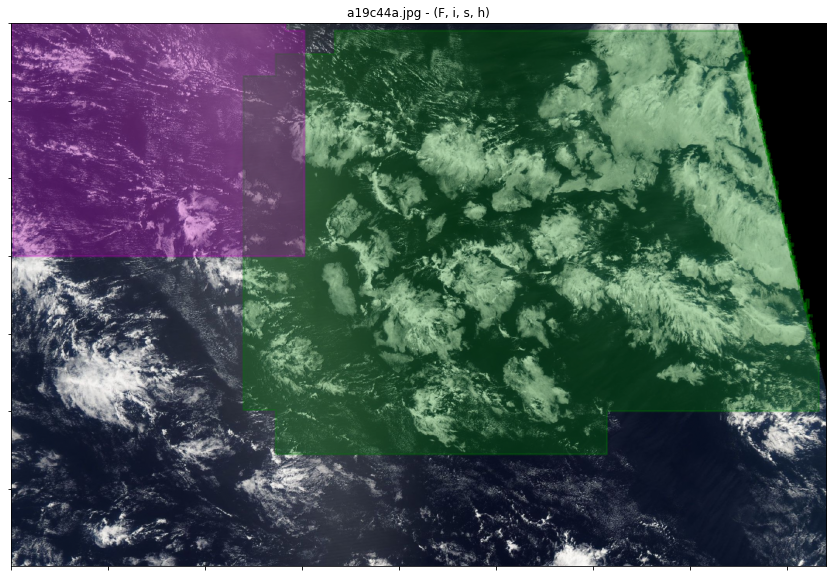

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bd001b3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00005_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00006_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00007_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00008_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00009_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00010_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00011_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bb75314.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00012_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00013_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/69e0742.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00090_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00091_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4b67f58.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00092_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00093_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00094_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00095_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/42ddf88.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00096_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00097_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/000

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/16d6983.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3e5339e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3c050f0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00174_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00175_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00176_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00177_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ea4f338.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00178_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00179_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/303cbec.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00180_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/07f403d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00251_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00252_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00253_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00254_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/485aa55.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00255_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/629b099.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00256_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00257_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00258_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9ddacce.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7d0c353.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d2b72aa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9af850c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00325_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00326_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8df3988.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00327_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00328_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00329_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00330_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00331_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00332_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00412_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00413_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00414_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00415_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00416_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00417_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/094e354.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00418_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00419_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c59bef7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00420_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/08e5ced.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2aeac67.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00507_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00508_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00509_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00510_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00511_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cc8c139.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7ca7d72.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00512_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00513_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00514_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/519820d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00574_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00575_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00576_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00577_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00578_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00579_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00580_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00581_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00582_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00583_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00660_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00661_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/448b41e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00662_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00663_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8391d85.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00664_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00665_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00666_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/87a1831.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00667_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5f90e8b.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d73a559.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00740_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00741_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ffbe4b8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00742_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00743_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00744_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00745_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/616ae44.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00746_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a9c7fd3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00747_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00818_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00819_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00820_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6c7d590.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00821_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00822_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00823_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00824_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00825_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00826_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00827_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00910_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00911_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b181a48.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00912_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00913_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00914_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00915_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00916_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00917_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00918_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00919_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00995_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/29f7bea.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00996_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00997_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00998_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/24188a2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/00999_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01000_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01001_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01002_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01003_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01072_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01073_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01074_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01075_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01076_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01077_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01078_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01079_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01080_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01081_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01082_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01160_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01161_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01162_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01163_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01164_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01165_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01166_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01167_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01168_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01169_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01170_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01250_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cf7b3f7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01251_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01252_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01253_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01254_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b27759f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/533d05b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/803e366.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01255_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01256_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01257_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01330_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01331_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01332_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01333_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01334_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01335_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01336_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01337_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01338_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01339_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01340_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/af9bb8e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01430_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01431_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/aad0a07.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01432_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e2b4f04.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01433_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01434_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6d91d1e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/afe8737.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/50c34af.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8ca9d01.jpg
/home/fbrient/Dropbox/Docu

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01515_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01516_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f6cd5e7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01517_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/30a24c5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01518_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01519_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8f424fe.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01520_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01521_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01522_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4976449.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b720db3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/044b59c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01594_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01595_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01596_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01597_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01598_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01599_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/90d430e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01600_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01601_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/016

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01681_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01682_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5b8ad7b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b6b6289.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01683_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01684_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3d43805.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5ada6a5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01685_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01686_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01687_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01688_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/42dca86.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01758_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01759_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/32583c0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01760_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01761_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01762_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01763_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01764_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/177cd56.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1abdd52.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bbde96d.jpg
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01836_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01837_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01838_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d836ac5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01839_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01840_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01841_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01842_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ae36c08.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01843_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4a188aa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/018

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01910_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f572ee9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01911_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01912_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01913_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01914_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01915_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01916_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5d3b861.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01917_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01918_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01991_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01992_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d3f605d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d635df8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01993_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01994_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9a8f69f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/780cd58.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bf287e6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1f9e9c8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01995_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/01996_anchor.png
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02070_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02071_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02072_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02073_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02074_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02075_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4c981c4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7589ed0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02076_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02077_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02078_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02144_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/dceebb5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02145_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02146_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cbba8f4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02147_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e19282c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02148_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02149_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/29f4c4d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02150_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02151_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5f0f098.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02235_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02236_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02237_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02238_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02239_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02240_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/62770f1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02241_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02242_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02243_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4c7f6ae.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5323f91.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5977273.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02316_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02317_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02318_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02319_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02320_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02321_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02322_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02323_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2b53ec3.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02394_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02395_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02396_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02397_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02398_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02399_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02400_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02401_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02402_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02403_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02404_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02476_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02477_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02478_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02479_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b9a909a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02480_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02481_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02482_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02483_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02484_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02485_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/t

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02562_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02563_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02564_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02565_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02566_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02567_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02568_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02569_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0ef0a95.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02570_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02571_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02646_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02647_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02648_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02649_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02650_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/df0a8ed.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/315475d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/806cd37.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02651_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02652_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02653_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/026

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7741fe0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/60b6d2c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5a17ad4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02742_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02743_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02744_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02745_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02746_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02747_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02748_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02749_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c908a85.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/259b3f7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02818_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02819_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02820_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02821_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02822_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02823_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02824_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02825_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0277e9a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02826_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02904_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02905_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02906_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02907_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02908_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02909_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5f00373.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02910_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02911_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02912_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/228ad71.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02988_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02989_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02990_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5e502b0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0ab1fb2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02991_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02992_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02993_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02994_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02995_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/02996_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/55b96f1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03066_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03067_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03068_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03069_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7abed17.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03070_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03071_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8270f6b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03072_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03073_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/030

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03137_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03138_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03139_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03140_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03141_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03142_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/136f59b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4e20128.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03143_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03144_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c938483.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/031

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9aacc76.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03229_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03230_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03231_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03232_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03233_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03234_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03235_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03236_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03237_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03238_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03309_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03310_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/231be51.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03311_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03312_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03313_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03314_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03315_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/85e5f09.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03316_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03317_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0d84609.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bb68923.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03402_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03403_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03404_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03405_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03406_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03407_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03408_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03409_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03410_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03479_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03480_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b1a41ac.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03481_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1d03a48.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/aa3c798.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03482_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03483_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/17a24a5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03484_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03485_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03486_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03550_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03551_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03552_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03553_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03554_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03555_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03556_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03557_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03558_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03559_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e2d4b91.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03623_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03624_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/08aa34b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03625_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03626_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a2019b3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2376acb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/801bf06.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03627_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03628_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03629_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03630_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03705_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03706_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03707_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a9facc6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03708_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03709_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03710_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03711_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03712_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03713_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03714_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/t

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03775_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03776_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fd8bf8a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7abf5fc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03777_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03778_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03779_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03780_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03781_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03782_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03783_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03876_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0c1d048.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03877_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/82469d0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03878_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03879_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03880_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03881_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/36198e2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03882_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03883_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/038

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03951_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/36a83e9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03952_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0aaa299.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03953_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03954_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03955_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03956_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03957_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/03958_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9ed2531.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/039

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04026_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04027_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04028_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04029_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ba92824.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/94b019e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04030_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04031_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04032_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04033_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/195f280.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/040

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04099_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04100_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04101_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6906aa0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04102_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04103_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04104_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04105_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04106_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04107_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04108_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04188_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4d7bcd8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04189_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1ccc7db.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04190_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04191_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04192_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04193_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04194_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04195_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04196_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6d0aa4a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04264_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04265_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04266_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04267_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f535ddd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04268_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c1b7cd4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04269_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04270_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04271_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/042

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04346_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04347_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04348_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8dd6979.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6eea687.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/08329b8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9749b58.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04349_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04350_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04351_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04352_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04353_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04432_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c9af416.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/38edef9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04433_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04434_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04435_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04436_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04437_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/485e7d4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04438_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c7e898c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04439_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cd6b401.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/abf0a99.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/924f4b8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9c1225f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04508_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04509_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04510_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04511_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04512_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9d07b0a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04513_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04514_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04596_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04597_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04598_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04599_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04600_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04601_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2502390.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e106ef8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e0cbf7e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04602_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c0b77e6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ac5a819.jpg
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04676_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04677_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04678_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04679_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/37d76b3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04680_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04681_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3b11de9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04682_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04683_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04684_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04751_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04752_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04753_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/63cdf82.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04754_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04755_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/63fb300.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/540fde7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04756_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04757_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04758_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/047

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/32af0bb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2d505dd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04838_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f260df3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04839_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04840_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04841_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04842_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04843_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04844_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8b6ba11.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04845_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04914_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04915_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/be0540d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04916_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04917_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04918_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04919_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04920_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04921_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04922_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04923_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cc475c4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/69586f7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04992_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04993_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04994_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04995_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04996_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04997_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04998_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/04999_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05000_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05071_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05072_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7490846.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/59b8208.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05073_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05074_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05075_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05076_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05077_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05078_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05079_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05144_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05145_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05146_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05147_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/15251c3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/37bb4cd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6d0d788.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05148_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05149_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/95b7214.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05150_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a21d2e5.jpg
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6c40a44.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05221_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05222_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05223_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05224_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05225_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f9cd52d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05226_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05227_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05228_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05229_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05304_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/023accd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05305_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05306_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05307_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05308_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05309_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05310_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05311_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05312_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05313_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05391_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/afd3da4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ecac2e7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05392_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05393_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05394_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05395_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05396_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05397_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8b93508.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05398_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/053

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05477_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05478_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05479_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05480_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05481_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05482_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f8b039c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05483_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05484_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05485_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05486_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a1d13fa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05552_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2b76910.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05553_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e7431c2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05554_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5e221da.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05555_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05556_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cb85236.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05557_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05558_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05629_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05630_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05631_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05632_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05633_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05634_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2ba7c9c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05635_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ee32824.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/027000d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05636_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/056

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05708_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/dd611a7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05709_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5ae83b1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05710_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05711_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05712_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05713_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7c730b5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/899b597.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05714_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05715_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05804_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05805_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05806_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6e00609.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/72c0d05.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05807_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05808_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f10e922.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05809_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05810_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05811_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/058

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05886_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05887_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05888_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05889_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05890_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05891_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05892_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05893_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05894_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05895_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05896_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/355039b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05963_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05964_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05965_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2317309.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05966_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05967_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05968_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05969_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05970_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/05971_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06040_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06041_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/dd4459d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/755b171.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/69c3d5d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/93db5c0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/50a3d6b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6e698d4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06042_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06043_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06044_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06045_anchor.png
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06116_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06117_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06118_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06119_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06120_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06121_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06122_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06123_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06124_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06125_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06126_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06193_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06194_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06195_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06196_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3b9a092.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/10401e7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06197_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06198_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06199_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06200_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06201_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d087b7b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06280_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06281_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06282_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06283_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06284_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06285_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06286_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06287_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4e619e0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6a52620.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/062

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06364_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06365_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06366_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06367_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06368_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06369_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06370_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06371_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f4f4403.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06372_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06373_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06454_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06455_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06456_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06457_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06458_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06459_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06460_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06461_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06462_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06463_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06464_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06540_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06541_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06542_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c5764a8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06543_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06544_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06545_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06546_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06547_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06548_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06549_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06619_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06620_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/73f91d5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/161d598.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06621_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06622_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06623_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06624_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06625_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06626_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06627_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06714_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06715_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06716_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06717_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cbab082.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06718_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06719_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06720_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06721_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06722_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/97834cb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9ede0ba.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/61d5e94.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/db06c8a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d02d349.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e9c309f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8fdc730.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06796_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06797_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06798_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06799_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06800_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/aaca0ba.jpg
/home/fbrient/Dropbox/Docu

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06866_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06867_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06868_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06869_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06870_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06871_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a9e8982.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06872_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06873_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06874_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06875_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06962_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06963_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06964_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06965_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06966_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06967_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06968_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06969_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06970_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06971_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/06972_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7f44f7f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07050_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07051_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07052_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07053_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/692fc30.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2e2dcc0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07054_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07055_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07056_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07057_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/070

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07135_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07136_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07137_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07138_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07139_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07140_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/12be717.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07141_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07142_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07143_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07144_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/t

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07211_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/be9ef65.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07212_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07213_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07214_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07215_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07216_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07217_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07218_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07219_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07220_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07288_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07289_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/86ab75c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07290_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07291_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07292_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e27810f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07293_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f0d3169.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07294_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07295_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/072

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4a7b6e3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07368_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/44a4171.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07369_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8857560.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07370_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07371_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07372_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07373_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07374_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07375_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/073

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5615b7f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07451_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07452_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07453_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07454_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07455_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e791403.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07456_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07457_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07458_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7b31be5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0e9deba.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07529_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07530_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07531_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f98a258.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/72d98da.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d60352a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07532_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07533_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07534_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07535_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07536_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e36c7a3.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/47f9395.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fe7ec44.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cabd615.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07608_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7b7d5ef.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/505fe43.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07609_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/252418d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07610_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07611_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07612_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07613_anchor.png
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07689_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07690_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07691_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07692_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07693_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07694_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07695_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07696_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07697_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07698_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/18fb01f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b7f1f9a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07765_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07766_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07767_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07768_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07769_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07770_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07771_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07772_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07773_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07774_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07853_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07854_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07855_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07856_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07857_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07858_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/853bcba.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07859_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07860_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07861_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07862_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0c2a033.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/358a9e4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4ac2abc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07939_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7c995c2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/823fe70.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07940_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07941_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07942_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07943_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07944_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/07945_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08016_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08017_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08018_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08019_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08020_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08021_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08022_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08023_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08024_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f2bc927.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08025_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/t

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08107_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08108_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2d9d608.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/363528a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08109_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08110_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08111_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08112_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08113_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08114_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08115_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08186_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08187_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08188_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08189_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08190_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08191_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08192_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8d52bae.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fc93558.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2011d14.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08193_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/081

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08273_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08274_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08275_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a52d1e7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08276_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08277_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08278_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08279_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08280_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08281_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08282_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08371_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/73bc1f8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08372_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08373_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08374_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08375_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08376_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08377_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5481727.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08378_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4aac315.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/88f228c.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08451_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08452_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08453_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08454_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08455_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08456_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08457_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08458_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08459_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08460_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08461_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c99e8d3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4aa465b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08531_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08532_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08533_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08534_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08535_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08536_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08537_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6d24fe8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08538_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/085

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d214f7a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08620_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08621_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08622_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08623_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08624_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08625_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08626_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08627_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08628_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08629_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08708_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08709_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08710_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08711_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08712_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08713_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/79e4563.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08714_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08715_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/34acd35.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/92b5191.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/985cea4.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08784_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08785_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08786_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ee14cd5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9609c2a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08787_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08788_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ecb4341.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08789_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08790_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08791_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6c584c5.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d265d38.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08865_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08866_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08867_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1c51d97.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08868_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/72d17be.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08869_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08870_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08871_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08872_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/088

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08960_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e672f32.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08961_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/40b5ace.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d24e67f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08962_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08963_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08964_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08965_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08966_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/08967_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/56b41f4.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e2ec3a8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7c297e3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09048_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09049_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/17c3e51.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09050_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09051_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09052_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fbc04e3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09053_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09054_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09055_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09127_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09128_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09129_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09130_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09131_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09132_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09133_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/99bf4b0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/777cef3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09134_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09135_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/db593d3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09201_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09202_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09203_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09204_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09205_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09206_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09207_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09208_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/28e90ae.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09209_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09290_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09291_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/447db03.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09292_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/dd9eff5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09293_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2184756.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09294_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09295_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09296_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09297_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/092

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09373_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1c7592c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09374_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09375_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09376_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09377_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/17aa1aa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/31dd939.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09378_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/426b015.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09379_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0862841.jpg
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1524b90.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9a4b29e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09449_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09450_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09451_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09452_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09453_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09454_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09455_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0c95a41.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4261637.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09456_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09524_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09525_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09526_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/297a26e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09527_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09528_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09529_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09530_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09531_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09532_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09533_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09606_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09607_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09608_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09609_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09610_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09611_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/50a7f92.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09612_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09613_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09614_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09615_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ce05fe6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09689_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09690_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09691_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09692_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7adf177.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3b10564.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09693_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09694_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e6fd8d4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09695_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09696_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09776_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/de31c99.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a88641f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09777_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09778_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/775038d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fada7d6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5ff8aa7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09779_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09780_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09781_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09782_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b78b1fe.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09848_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09849_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e83d2c5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09850_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9a4f665.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09851_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09852_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09853_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09854_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09855_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/098

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09917_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09918_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09919_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09920_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bacd6fe.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09921_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09922_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09923_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09924_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09925_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/09926_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/385672f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10003_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10004_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10005_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4d07564.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10006_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10007_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/84528d8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10008_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10009_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10010_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/100

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10091_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10092_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ebd4dc2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10093_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10094_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a8fcc43.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c06c8c1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10095_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10096_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10097_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10098_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/100

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/39f8e06.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10180_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10181_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10182_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10183_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10184_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10185_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10186_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10187_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10188_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/13df2eb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2bccb00.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10259_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10260_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10261_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10262_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/729e50e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4323dbb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10263_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ccbadef.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1e5f240.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0ac087b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10264_anchor.png
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10339_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5499691.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4385e54.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10340_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10341_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10342_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10343_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10344_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10345_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10346_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10347_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10426_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10427_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10428_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b07e554.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10429_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10430_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10431_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10432_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10433_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10434_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10435_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10503_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10504_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10505_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10506_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10507_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10508_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10509_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0cf6773.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10510_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10511_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5e94ac3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10577_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10578_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10579_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2caa0fe.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10580_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10581_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10582_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10583_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10584_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10585_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10586_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10660_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e612e1b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10661_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10662_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10663_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d9949bd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10664_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10665_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f178151.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10666_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10667_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/106

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10726_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10727_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10728_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10729_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10730_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10731_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10732_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10733_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10734_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10735_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10736_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10805_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10806_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10807_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10808_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cd40ced.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10809_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/065623d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10810_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10811_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d6f2c31.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/aed31c2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10812_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/69787a6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10893_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10894_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10895_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10896_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10897_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10898_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10899_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10900_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10901_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10902_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10979_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/13123f6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c8d7934.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/93e44c0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10980_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10981_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10982_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10983_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10984_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10985_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/10986_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/109

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11062_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11063_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11064_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11065_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8ef7180.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a2f5708.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11066_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11067_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11068_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11069_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11070_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11143_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11144_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11145_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11146_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/95b4424.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1822ac7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7e0d818.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11147_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11148_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c8aeed6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11149_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11150_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11222_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11223_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11224_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11225_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fd1da12.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11226_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11227_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11228_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11229_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11230_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11231_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11302_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11303_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f203606.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11304_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/be72ff8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11305_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11306_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11307_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11308_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11309_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11310_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11385_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11386_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7273621.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/601eb93.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11387_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11388_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7fd44b1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11389_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11390_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11391_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11392_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/113

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11467_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11468_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11469_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11470_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11471_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b0f27b0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11472_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11473_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/64ab7ee.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2537d51.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11474_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/114

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11545_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f434b17.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11546_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11547_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11548_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11549_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5693edc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11550_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11551_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11552_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1e45053.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/03ed174.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11621_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11622_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11623_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11624_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11625_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11626_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11627_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11628_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11629_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11630_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11631_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11709_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11710_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11711_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11712_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11713_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11714_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11715_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11716_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2ede37a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11717_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11718_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c87b0ff.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bdfdc01.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11791_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11792_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11793_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/473ca3a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/424f7a3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11794_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11795_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11796_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/60d58bc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11797_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11879_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11880_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bb83655.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/84133eb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11881_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11882_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11883_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11884_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11885_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11886_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11887_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/589c00e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f1d14cd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11965_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11966_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11967_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11968_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11969_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11970_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11971_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11972_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/11973_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12040_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12041_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12042_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12043_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12044_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12045_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12046_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12047_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12048_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f720180.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12049_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12121_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12122_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7647926.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12123_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4efb7c0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12124_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12125_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9303b5c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12126_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/12af2d9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12127_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12128_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12200_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12201_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/12b2ee4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12202_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12203_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5a4cb07.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12204_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12205_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/060ce39.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12206_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12207_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/122

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5aa9d5c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12277_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12278_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12279_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12280_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12281_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/62232d8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c06322b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6aa11d4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12282_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/459bd29.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12283_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12362_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12363_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fb0827a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12364_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/40dd239.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12365_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/de0dacd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12366_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b8add71.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12367_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12368_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12369_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12439_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12440_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f14772a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12441_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12442_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12443_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12444_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12445_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12446_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12447_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12448_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7badec2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12520_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12521_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/09d0eee.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12522_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12523_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12524_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12525_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12526_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12527_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12528_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2d6d2f2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12608_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a5f6d6b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12609_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12610_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12611_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12612_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12613_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12614_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12615_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12616_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12690_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12691_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12692_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12693_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3fc1779.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3f79584.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12694_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12695_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12696_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12697_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12698_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12769_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12770_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12771_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12772_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e48ea19.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12773_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12774_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12775_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/692d0a4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12776_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12777_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12853_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12854_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12855_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12856_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12857_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12858_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12859_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12860_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12861_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12862_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12863_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f58541c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/84870a0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12933_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12934_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7530397.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12935_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/93d8e30.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12936_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12937_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12938_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12939_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/12940_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/90c4abe.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13008_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e074625.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13009_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/82abf39.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13010_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13011_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13012_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13013_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13014_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13015_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/130

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13084_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13085_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13086_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13087_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13088_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13089_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13090_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13091_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d746b58.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13092_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13093_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13178_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13179_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/171e62f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13180_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13181_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13182_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13183_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13184_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13185_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13186_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13187_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cc10d21.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13273_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f11b05a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ecd5445.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/af4d36b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5c92503.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13274_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13275_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13276_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13277_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/679d921.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13278_anchor.png
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13350_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13351_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13352_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f485249.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13353_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/42106bf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13354_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13355_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13356_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0cabeda.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13357_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/133

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b8ffe62.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d0f3324.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3220621.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13429_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13430_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13431_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ffd11b6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13432_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13433_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13434_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13435_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d4a9c38.jpg
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6c4e78f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b917f16.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13503_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13504_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13505_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13506_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13507_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13508_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13509_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13510_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13511_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4f1c86a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e3a2bfb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13588_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13589_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13590_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13591_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13592_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/938bf7a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13593_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13594_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13595_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/135

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/59ef2ad.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13674_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13675_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bbfc670.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13676_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5283dcf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13677_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1ae4549.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13678_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13679_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13680_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13681_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13764_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13765_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13766_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13767_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13768_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9c25a72.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13769_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13770_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ec5fab8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13771_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13772_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a1f40d5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2b2c1f9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13846_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1fff557.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/560dedf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13847_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13848_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13849_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13850_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13851_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13852_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13853_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13934_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13935_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13936_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13937_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13938_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13939_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13940_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13941_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b07ed28.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/948a898.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/13942_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14001_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14002_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14003_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14004_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14005_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14006_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9d60372.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14007_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14008_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14009_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14010_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14078_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/99a13e5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14079_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14080_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14081_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14082_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f3d3997.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14083_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/498dd40.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14084_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14085_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/140

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14164_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14165_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d9bc3a5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14166_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14167_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14168_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14169_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14170_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14171_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14172_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14173_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/81fb17b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14255_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14256_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14257_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14258_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14259_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14260_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14261_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4a0f769.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14262_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14263_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3865225.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ddb9ef1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14335_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2107837.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14336_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c806fcf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14337_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14338_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14339_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14340_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f13cbe0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14341_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14420_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14421_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14422_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14423_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14424_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14425_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14426_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f6af9ef.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8673664.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14427_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14428_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14501_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14502_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14503_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14504_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14505_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14506_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14507_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14508_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14509_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14510_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14511_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14588_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14589_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14590_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14591_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14592_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14593_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14594_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14595_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14596_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14597_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b2097d0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14666_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14667_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3cc849a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14668_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14669_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14670_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14671_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14672_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14673_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a6402b6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14674_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14746_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14747_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14748_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14749_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14750_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14751_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14752_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14753_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5e91be2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/043e76c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14754_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/aa4ba79.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6ffe24a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d396efb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14820_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14821_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/49d3729.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14822_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14823_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14824_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14825_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14826_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14827_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14896_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14897_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14898_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14899_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14900_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/913fa0d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14901_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14902_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e2e8ad6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14903_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14904_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f90e90d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14973_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14974_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/964e0ba.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14975_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e860c5b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14976_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14977_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14978_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14979_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/14980_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/149

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15063_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15064_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15065_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15066_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15067_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15068_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15069_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15070_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15071_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15072_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/523527f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15152_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15153_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15154_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15155_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15156_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15157_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15158_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15159_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15160_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15161_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15162_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15229_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15230_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15231_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15232_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15233_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15234_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15235_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15236_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15237_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15238_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bb62c4a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/506e9d9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15312_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c6f8044.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15313_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15314_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/09cfd7c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15315_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15316_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e530d59.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e37eacf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15317_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15318_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f43dad3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6c2bd59.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15401_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15402_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15403_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15404_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c6b1b36.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/463f786.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/860f67f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/538eb3e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15405_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15406_anchor.png
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7bd90b9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15480_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/76ada9f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15481_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5eb72aa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e02cc61.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15482_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bc79c87.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15483_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15484_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15485_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15486_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15564_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15565_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7b7042d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15566_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15567_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15568_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cc1d83b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/927a12d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15569_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15570_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8be8471.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15571_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15644_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15645_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15646_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15647_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15648_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15649_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15650_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15651_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1945738.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15652_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b21394c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15737_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15738_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15739_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15740_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15741_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15742_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15743_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/74e1590.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15744_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/67eb9ec.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3dd9bfd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/157

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6d333f7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7b396e6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f4e82e9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15818_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15819_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15820_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15821_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15822_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15823_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15824_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15825_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/158

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15911_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15912_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15913_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15914_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15915_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2a77bb5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5ddc6fb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15916_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15917_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15918_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15919_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ecefc50.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15995_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15996_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15997_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/332cb5c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15998_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/15999_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b8810ca.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16000_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16001_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16002_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/160

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16081_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16082_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16083_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/da918d4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c5b8987.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16084_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/df69207.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/72dbc06.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16085_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16086_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16087_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16088_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16155_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16156_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16157_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16158_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16159_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16160_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a44d1c0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e7f8bd2.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/89385df.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9c3a9b0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c71b0dc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f03b8c0.jpg
/home/fbrient/Dr

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16230_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16231_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16232_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16233_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16234_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16235_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16236_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16237_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16238_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16239_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16240_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16314_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16315_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16316_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16317_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16318_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16319_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16320_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16321_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16322_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16323_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16324_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16403_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16404_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16405_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16406_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16407_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16408_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7cd7991.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16409_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16410_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16411_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16412_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/t

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16491_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16492_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16493_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16494_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16495_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16496_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16497_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16498_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16499_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4c60d33.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16500_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16577_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16578_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16579_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16580_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16581_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16582_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16583_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16584_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16585_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16586_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16587_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16662_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16663_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/14d1403.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16664_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16665_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16666_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16667_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16668_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16669_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16670_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16671_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2e00025.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16740_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16741_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16742_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16743_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16744_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16745_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16746_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16747_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16748_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/48a3430.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16825_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16826_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16827_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16828_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/021bb26.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3c9865d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16829_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7c8e4c5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16830_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16831_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16832_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/168

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16919_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16920_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16921_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16922_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16923_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16924_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16925_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16926_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16927_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16928_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/16929_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3d2ca1b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17011_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17012_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17013_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17014_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17015_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17016_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0ab6229.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/624f5eb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/148a6ef.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17017_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17018_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17082_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/adf72bf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17083_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17084_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17085_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8201178.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17086_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17087_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17088_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17089_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17090_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17164_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17165_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17166_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17167_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17168_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17169_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8bf3d51.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1b62d67.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/72d507b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17170_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17171_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a47704b.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17241_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/14de64b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/518a110.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17242_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17243_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17244_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17245_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17246_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0fb64d9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17247_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17248_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/172

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17324_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17325_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17326_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17327_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17328_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17329_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17330_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17331_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17332_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17333_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7bdcd44.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b570e82.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17402_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17403_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17404_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17405_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17406_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17407_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17408_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17409_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17410_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/dd938fa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17492_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17493_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17494_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17495_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ed6de80.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17496_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e317214.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c73913d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17497_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17498_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17499_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/175

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5a59da4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17570_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17571_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/aff529b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17572_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17573_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17574_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17575_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d0325e9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/81f039b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6e20484.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17576_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/576d516.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17651_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17652_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17653_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c65a8be.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17654_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17655_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17656_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17657_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17658_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17659_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17728_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17729_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17730_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17731_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17732_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17733_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17734_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e5acc2e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17735_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fabf96b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17736_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17799_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17800_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17801_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17802_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17803_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ae7a06d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/af408e8.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17804_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17805_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fdd7492.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17806_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/178

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17893_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17894_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/361e863.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17895_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17896_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/af89c90.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ae47f2b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e53dacc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17897_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17898_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5b6548c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17899_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17984_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/74faa9f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17985_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17986_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17987_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17988_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17989_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17990_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17991_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17992_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/17993_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18079_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18080_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18081_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18082_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18083_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6c01e7d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/dc297df.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18084_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18085_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4f3407b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18086_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/180

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6b05dcf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2a7aaee.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18159_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18160_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18161_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18162_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18163_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18164_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9b1854a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18165_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18166_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/181

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18249_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/75a1709.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18250_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18251_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18252_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18253_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18254_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f954bde.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18255_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18256_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18257_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18323_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18324_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18325_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18326_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18327_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18328_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18329_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18330_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18331_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18332_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/91c1163.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18407_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cd29cec.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18408_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18409_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d0153c6.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18410_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18411_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18412_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18413_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18414_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18415_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18500_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18501_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18502_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18503_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18504_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4e5b275.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18505_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18506_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18507_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18508_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18509_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18581_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18582_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/bdbce0f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18583_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18584_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18585_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18586_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/372b2b3.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18587_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18588_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18589_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18661_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18662_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18663_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a6e668c.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18664_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18665_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18666_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18667_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/2b03476.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18668_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18669_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/d6a057a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18743_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18744_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18745_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18746_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18747_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18748_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18749_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18750_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e59cec9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18751_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18824_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18825_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18826_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18827_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0a60891.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4b9d085.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/51d19b4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18828_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/015aa06.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18829_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18830_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18831_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18902_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18903_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18904_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18905_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18906_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18907_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18908_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18909_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18910_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7c6474b.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18911_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f4dc2aa.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18989_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18990_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18991_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18992_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ff3247e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18993_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18994_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18995_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/18996_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4352c3a.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/189

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/e51e143.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b6a226f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19073_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19074_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19075_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19076_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19077_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19078_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19079_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19080_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19081_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19148_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19149_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19150_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19151_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19152_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c6e5c16.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19153_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/8ebc816.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19154_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ffcd7ef.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cc1bc90.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19155_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19227_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19228_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19229_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19230_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19231_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19232_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19233_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/3e16ccd.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19234_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19235_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0432314.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7b7ed62.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6ea4ca9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19312_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19313_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/23e204e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19314_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19315_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19316_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19317_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19318_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9871dc7.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19319_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19409_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/f419d8e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19410_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19411_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19412_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19413_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19414_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19415_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19416_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19417_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19418_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/t

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19488_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19489_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19490_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19491_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19492_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c2e72a5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/345e596.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19493_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19494_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19495_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19496_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6954376.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a229d7f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19567_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19568_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19569_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19570_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19571_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19572_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19573_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19574_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1860780.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/195

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19647_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/cc3574f.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/77977fc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19648_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19649_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19650_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19651_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19652_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19653_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19654_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19655_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19727_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19728_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19729_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19730_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19731_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5ee76bb.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19732_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19733_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/6ac28c1.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19734_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19735_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/95b40a5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19801_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19802_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19803_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19804_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19805_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19806_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19807_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19808_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19809_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19810_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a733766.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0eee242.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/c524c35.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/84b84da.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19881_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19882_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19883_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19884_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19885_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19886_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19887_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19888_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19964_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19965_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19966_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19967_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19968_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19969_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7fb53c9.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19970_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19971_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/19972_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1013c1d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_image

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0f5f991.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20045_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/94d706e.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/ebd7bef.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20046_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20047_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0ad0a05.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20048_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20049_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20050_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1ab3ae5.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20051_anchor.png
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/fd1610d.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/1ea27d0.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20132_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/b90ed50.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20133_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20134_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20135_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/a824cdc.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20136_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20137_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20138_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9a4535a.jpg
/home/

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/0ece863.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20208_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20209_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/5988f45.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20210_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20211_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20212_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20213_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20214_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/7f04e28.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/4d8f632.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20215_anchor.

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20286_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20287_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20288_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20289_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20290_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20291_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20292_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20293_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20294_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20295_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20296_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Dat

/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20373_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9219fe4.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20374_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20375_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20376_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20377_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/685cb03.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20378_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/9885488.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20379_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20380_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/203

/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/train_images/51c3adf.jpg
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20448_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20449_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20450_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20451_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20452_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20453_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20454_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20455_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20456_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/train/20457_anchor.png
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVER

In [32]:
# Copy of creating_tiles_datasets
# Should not be used to avoid double
# But need labs...
labs = []
shown = False
t = 0
DATASETS_path = "/home/fbrient/Dropbox/Documents/EUREC4A/Data/"
pathout = DATASETS_path+ 'ZOONIVERSE_DIVIDED/'
for sample in tqdm(train_samples):
        if not shown:
            fig, ax = plt.subplots(figsize=(15, 10))
        img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
        print(img_path)
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #plt.imshow(img)
        #plt.show()
        # Get annotations
        labels = df[df['Image_Label'].str.contains(sample[0])]['EncodedPixels']

        patches = []
        for idx, rle in enumerate(labels.values):
            if rle is not np.nan:
                mask = rle2mask(rle)
                #maskn = mask.copy()
                #mask = np.ascontiguousarray(mask , dtype=np.uint8)
                contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                #print("Contours : "+str(contours))
                rgbImg = extract_contour(img, contours, shown=shown)
                rgbImg = cv2.cvtColor(rgbImg, cv2.COLOR_BGR2RGB)


                # Choose random X and Y shifting 


                for x in range(0, rgbImg.shape[0], 256):
                    for y in range(0, rgbImg.shape[1], 256):
                        if rgbImg[x:x+256,y:y+256].shape != (256, 256, 3) or [0,0,0] in rgbImg[x:x+256,y:y+256]:
                            continue

                        


                        tm = t
                        out_name = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='anchor')
                        
                        out_name = pathout+'train/'+out_name
                        #out_name = DATASET_DIR+'train/'+out_name
                        cv2.imwrite(out_name,rgbImg[x:x+256,y:y+256])
                        t += 1
                        labs.append(idx)
                        print(out_name)
                if not shown:
                    for contour in contours:
                        poly_patch = Polygon(contour.reshape(-1, 2), closed=True, linewidth=2, edgecolor=COLORS[idx], facecolor=COLORS[idx], fill=True)
                        patches.append(poly_patch)
        if not shown:
            shown = True
            p = PatchCollection(patches, match_original=True, cmap=matplotlib.cm.jet, alpha=0.3)

            ax.imshow(img/255)
            ax.set_title('{} - ({})'.format(sample[0], ', '.join(sample[1].astype(np.str))))
            ax.add_collection(p)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.show()

## Creating tiles dataset

In [9]:
#dataset_path =  '../../NC/division/'
dataset_path = DATASETS_path+ 'ZOONIVERSE_DIVIDED/'
#dataset_path =  '/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_TRAIN/'
tile_dataset = ImageSingletDataset(data_dir=dataset_path, tile_type=TileType.ANCHOR)
print(tile_dataset)

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Predicting embedding of zooniverse

In [10]:
da_embeddings = get_embeddings(tile_dataset=tile_dataset, model=model)

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 640/640 [17:34<00:00,  1.65s/it]


In [11]:
print(da_embeddings.data[2,:])

[-8.83960202e-02 -1.91417620e-01 -1.38232961e-01 -8.18237811e-02
  8.21874291e-03 -1.10317707e-01  1.30017072e-01 -3.62278104e-01
 -3.91353607e-01  1.30449936e-01  3.83532047e-01  1.51948333e-02
  1.38250470e-01 -3.05563152e-01 -3.53602409e-01 -1.41425014e-01
 -7.61878565e-02 -8.00630674e-02  3.18520695e-01  1.80363908e-01
 -1.36894345e-01 -2.42913693e-01  6.88113123e-02  9.23247576e-01
 -1.63391203e-01 -1.10350460e-01  1.07754916e-01  5.08445382e-01
 -3.36826742e-02 -2.89954156e-01  1.37713358e-01  3.60933840e-01
  3.41569722e-01  7.73007125e-02  2.00794190e-01  5.66423297e-01
 -1.49253443e-01 -1.48084104e-01 -1.81839034e-01  2.24501893e-01
  4.54065911e-02 -3.77309144e-01 -2.30111152e-01 -3.35082233e-01
  5.81188560e-01 -1.00365959e-01 -1.82349235e-02  2.22603798e-01
 -1.20985672e-01  2.21908316e-01  6.41720533e-01  5.51607847e-01
  7.95381516e-02 -1.24640167e-01  1.17257506e-01 -1.67412102e-01
  2.60810912e-01  2.04130754e-01  1.39787138e-01  2.17021540e-01
  1.06383157e+00  6.34634

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


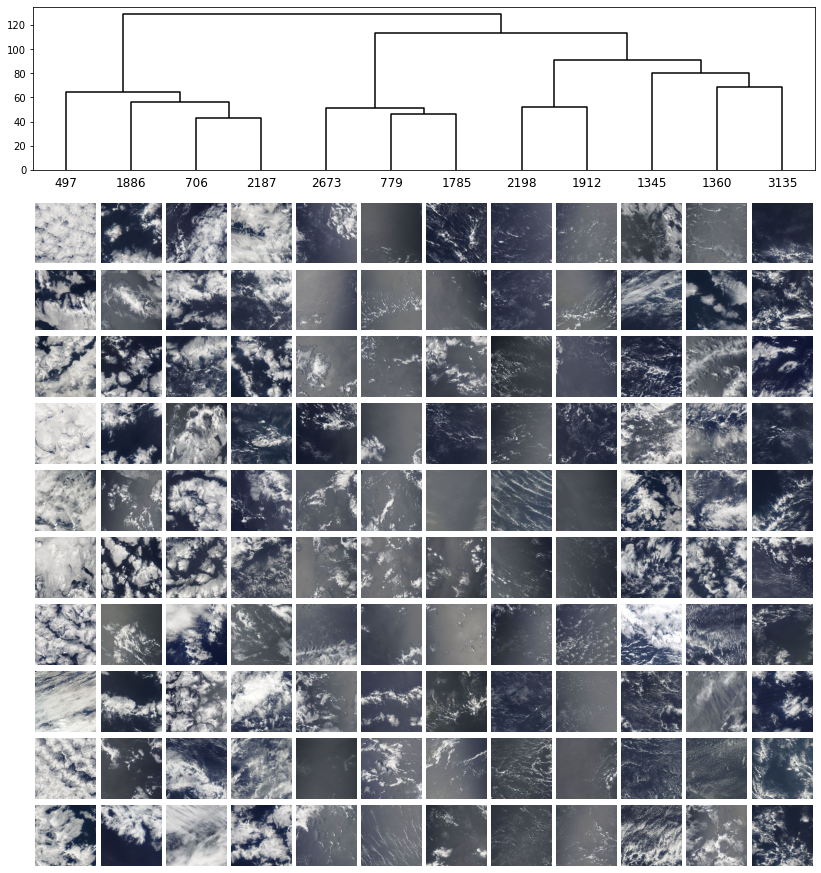

In [13]:
clusters = convml_tt.interpretation.plots.dendrogram(da_embeddings, n_samples=10, n_clusters_max=12, return_clusters=True)

In [35]:
import importlib
import utils
importlib.reload(utils)
print(visualize_boxes_cluster)
print(DATASET_DIR)


4.5.3
<function visualize_boxes_cluster at 0x7f167ab27670>
/home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED/ /home/fbrient/Dropbox/Documents/EUREC4A/Data/Kaggle/
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05378_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00568_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14804_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06432_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02347_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03109_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07457_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07828_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13328_anchor.png
Tr

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13765_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18580_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13405_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09928_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17396_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19671_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17770_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11377_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04836_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06506_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14146_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10312_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14092_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06271_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12475_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07252_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17098_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03023_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07355_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06916_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07797_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17970_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09632_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17239_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12089_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04702_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01257_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14446_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03656_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04003_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/08657_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11383_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10565_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15655_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12401_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18121_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16311_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06827_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01842_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09725_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04135_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/08582_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07353_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07999_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17692_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09391_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09816_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06791_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13143_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02412_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11459_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16040_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18648_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10534_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16359_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13517_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04521_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17968_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19548_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03151_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13190_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16559_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13804_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10221_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09699_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03790_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19378_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14361_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05812_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09869_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16060_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07678_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18904_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05716_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01590_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11218_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15106_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03494_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09801_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05541_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03081_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01014_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13520_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17498_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18762_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/08482_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02822_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13404_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00537_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10115_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17001_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17319_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12433_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04886_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01997_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11801_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05537_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02420_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10324_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11960_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05577_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11340_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15864_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06904_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12720_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04752_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01281_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15261_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00699_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13343_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18174_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00791_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07997_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/20173_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05776_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02373_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09463_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09677_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00354_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16700_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19812_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06200_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04393_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00424_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16612_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03733_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15823_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09347_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17808_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10289_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11360_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12333_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07267_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07090_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02558_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00007_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09535_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18772_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13875_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02552_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07047_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15802_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12232_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12420_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/20397_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13912_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09875_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09920_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07511_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06295_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10369_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19661_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07058_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17780_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12399_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02623_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16050_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/08848_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14168_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06058_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01073_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01420_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02212_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00606_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17436_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/20359_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00389_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16176_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04763_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03769_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05867_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04769_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19093_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12376_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/18296_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19591_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10251_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15797_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11247_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19100_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14491_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16621_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02882_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06853_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/20102_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/15058_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05469_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04835_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03338_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11732_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04808_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/10036_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03543_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/02116_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17346_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12396_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06929_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/00916_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12526_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/19653_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/13702_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05315_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/11000_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07235_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/05913_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/14967_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/17079_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01610_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/09945_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06557_anchor.png
True False

True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/01495_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/12216_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/07091_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06049_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/03773_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/08042_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/06740_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/16824_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04025_anchor.png
True False
/home/fbrient/Dropbox/Documents/EUREC4A/Data/ZOONIVERSE_DIVIDED//train/04952_anchor.png
True False

/home/fbrient/GitHub/convml_tt_internship/data_analysis/zooniverse/utils.py:226: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_xticklabels([])


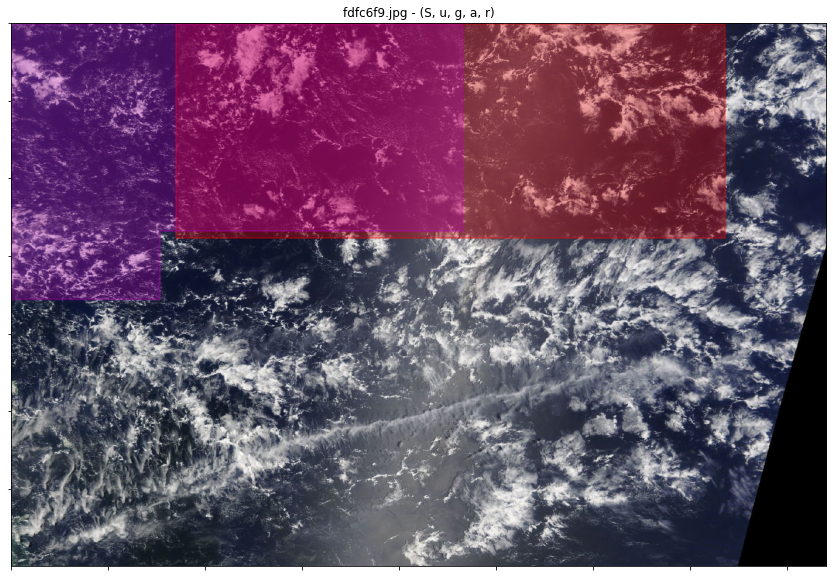

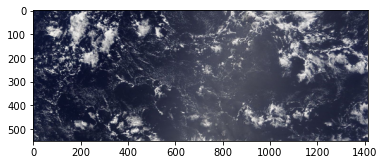

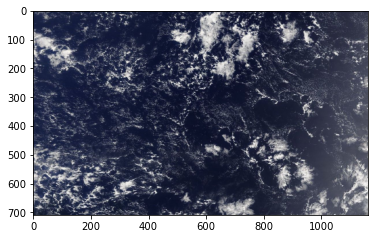

NameError: name 'model' is not defined

In [36]:
# Problem with get_embedding in visualize_boxes_cluster. 
# Why asking the model an other time? How Did Rayan? 
from utils import visualize_boxes_cluster
from utils import visualize_domain
member = randint(0, len(train_samples))
#print(member,train_samples[member],df)
path_tmp = DATASETS_path+ 'ZOONIVERSE_DIVIDED/' #dataset_path
path_train_images = DATASET_DIR
visualize_boxes_cluster(df, train_samples[member],path_tmp,path_train_images)
#visualize_domain(df, train_samples[member],path_tmp,path_train_images)


## Predicting confusion matrices

In [50]:
print(len(clusters[1]))
print(len(labs))

#print(clusters[1])
print(labs)

20463
20463
[1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 0, 1, 1, 3, 3, 0, 0, 1, 1, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 2, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 0, 2, 2, 0, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 0, 0, 2, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 0, 0, 

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
cfs_mat = confusion_matrix(labs, clusters[1])

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
print(cfs_mat.shape)
print(cfs_mat[:4,:])
print(cfs_mat)

(12, 12)
[[ 262  367  215  769  545  130  266  169  214  263  416  636]
 [ 166 1308  415  966 1341  204  475  178  266  146  298  977]
 [  45  108   42  225  305  160  308  350  361  364  209  625]
 [  24  103   34  227  482  285  736 1501 1071  572  437  897]]
[[ 262  367  215  769  545  130  266  169  214  263  416  636]
 [ 166 1308  415  966 1341  204  475  178  266  146  298  977]
 [  45  108   42  225  305  160  308  350  361  364  209  625]
 [  24  103   34  227  482  285  736 1501 1071  572  437  897]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 12)
(4,)
[4252 6740 3102 6369]
(12, 4)


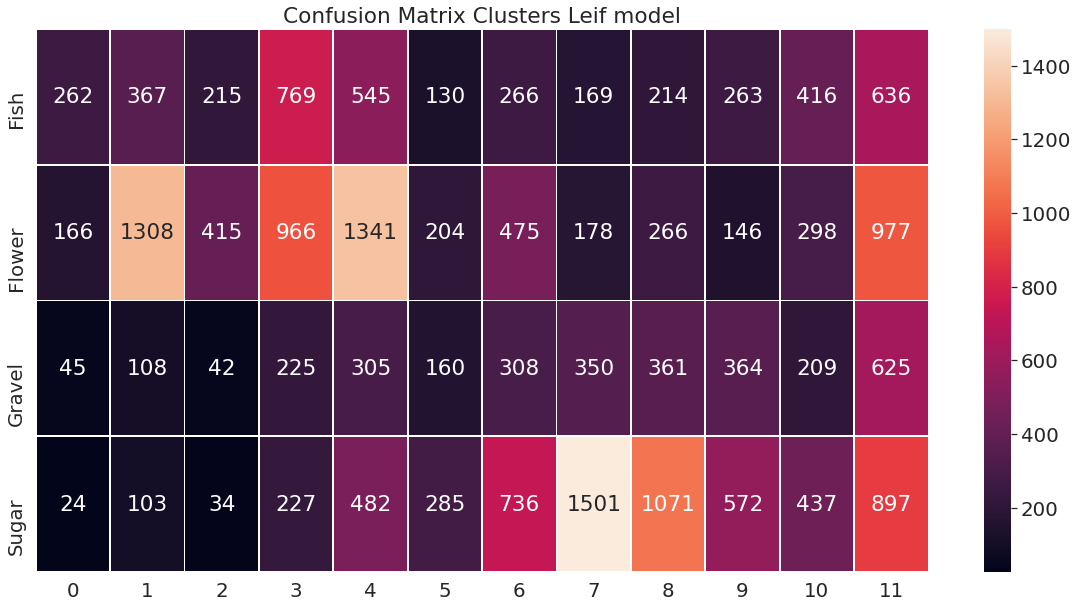

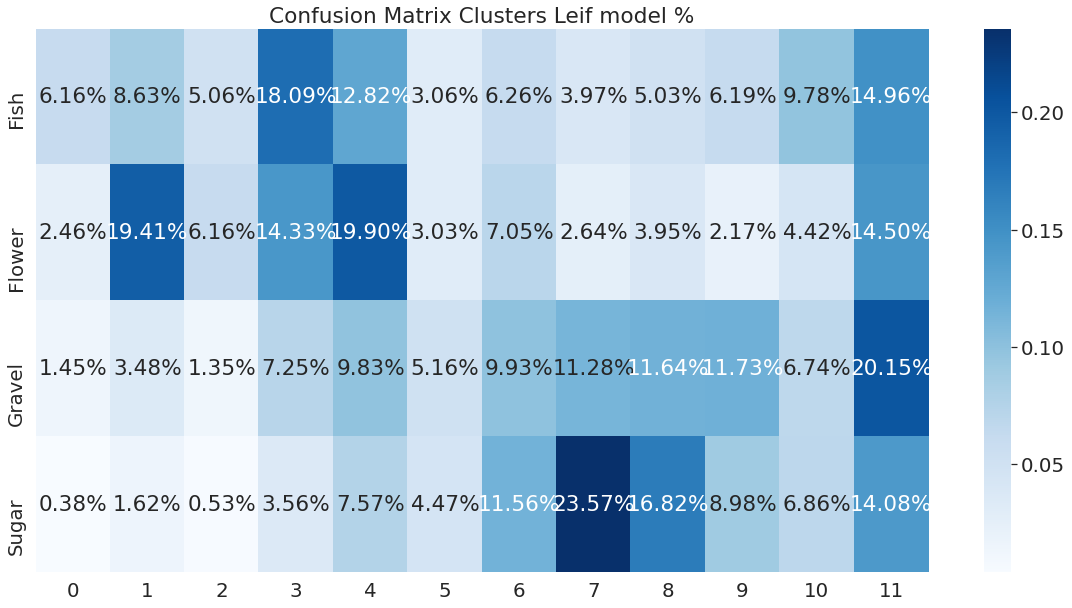

In [61]:
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']

fig, ax = plt.subplots(figsize=(20,10)) 
plt.title("Confusion Matrix Clusters Leif model")
sns.set(font_scale=1.8)
sns.heatmap(cfs_mat[:4,:], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
plt.savefig('Confusion_matrix_1.png')

fig, ax = plt.subplots(figsize=(20,10))
print(cfs_mat[:4,:].shape)
print(   np.sum(  cfs_mat[:4,:], axis=1  ).shape  )
print(np.sum(  cfs_mat[:4,:], axis=1  ))
print(   (  cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)    ).shape  )
plt.title("Confusion Matrix Clusters Leif model %")
sns.heatmap( (cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)).T, annot=True, 
            fmt='.2%', cmap='Blues' , yticklabels=associations)
plt.savefig('Confusion_matrix_2.png')


# Random Dirichlet

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4252.0
6739.999999999998
3102.0000000000005
6369.0
[[ 317.  230. 1005.  412.  554.  306.  808.  155.  322.   69.   56.   19.]
 [ 653.  635. 1913.   86.  621.  780.  349.  188.  368.   15.  481.  651.]
 [  14.  167.   31.  253.  729.  191.  124.   82.  952.   62.  192.  305.]
 [ 469.  618.  366.  936.  729.  418.  340.   31.  624.  216. 1148.  475.]]
(4, 12)
(4,)
(12, 4)


<AxesSubplot:title={'center':'Confusion Matrix Random Dirichlet %'}>

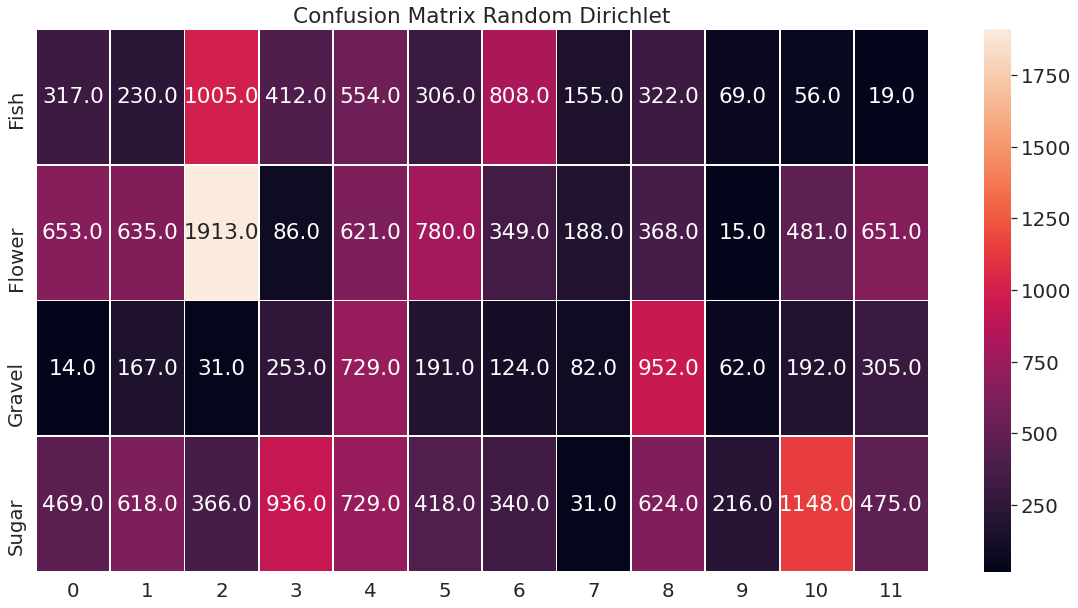

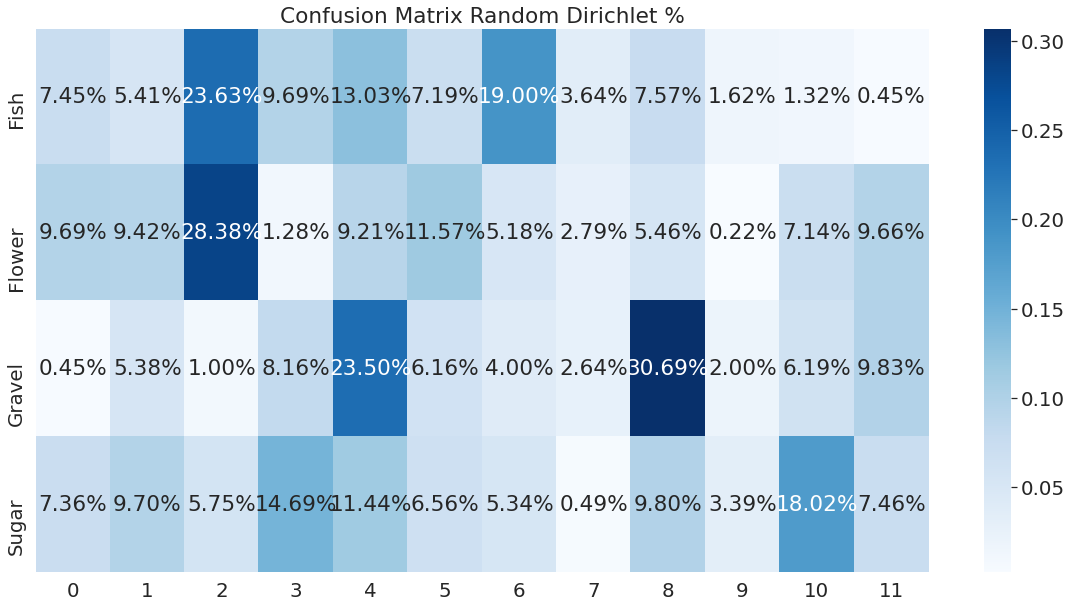

In [67]:
import seaborn as sns
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
numbers = [4252,6740, 3102, 6369]
conf_mat = []
for num in numbers:
    row = np.random.dirichlet(np.ones(12),size=1)*num
    print(np.sum(row))
    conf_mat.append(np.round(row[0]))
cfs_mat = np.array(conf_mat)
print(cfs_mat)
#cfs_mat = confusion_matrix(labs, clusters[1])

fig, ax = plt.subplots(figsize=(20,10)) 
plt.title("Confusion Matrix Random Dirichlet")


sns.set(font_scale=1.8)
sns.heatmap(cfs_mat[:4,:], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
fig, ax = plt.subplots(figsize=(20,10))
print(cfs_mat[:4,:].shape)
print(   np.sum(  cfs_mat[:4,:], axis=1  ).shape  )
print(   (  cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)    ).shape  )
plt.title("Confusion Matrix Random Dirichlet %")
sns.heatmap( (cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)).T, annot=True, 
            fmt='.2%', cmap='Blues' , yticklabels=associations)

# Random Uniform

/home/fbrient/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 12)
(4, 12)
(4,)
(12, 4)


<AxesSubplot:title={'center':'Confusion Matrix Random Uniform %'}>

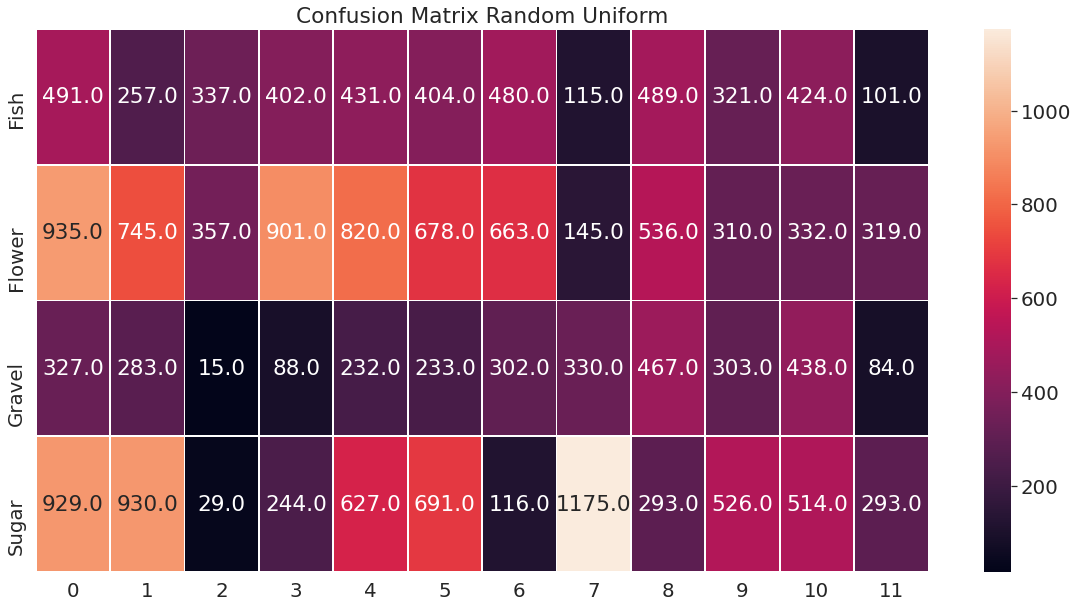

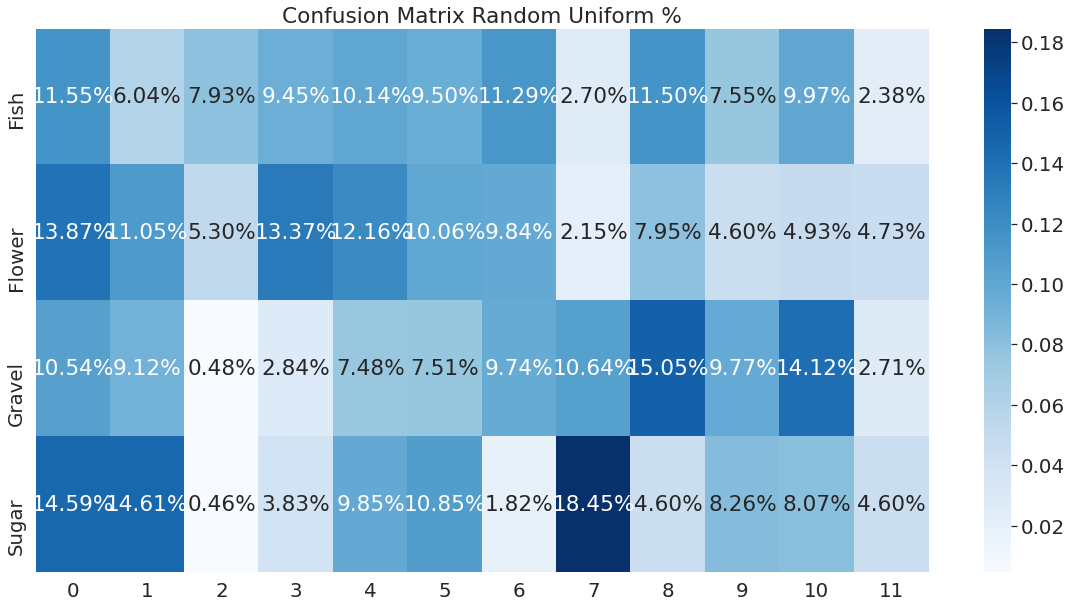

In [68]:
import seaborn as sns
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
numbers = [4252,6740, 3102, 6369]
conf_mat = []
for num in numbers:
    row = np.random.uniform(size=12)
    row = row/row.sum()
    row = row*num
    #print(row)
    conf_mat.append(np.round(row))
#print(row)
cfs_mat = np.array(conf_mat)
#print(cfs_mat)
#cfs_mat = confusion_matrix(labs, clusters[1])
print(cfs_mat.shape)
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Confusion Matrix Random Uniform")
sns.set(font_scale=1.8)
sns.heatmap(cfs_mat[:4,:], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
fig, ax = plt.subplots(figsize=(20,10))
print(cfs_mat[:4,:].shape)
print(   np.sum(  cfs_mat[:4,:], axis=1  ).shape  )
print(   (  cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)    ).shape  )
plt.title("Confusion Matrix Random Uniform %")
sns.heatmap( (cfs_mat[:4,:].T/np.sum(cfs_mat[:4,:], axis=1)).T, annot=True, 
            fmt='.2%', cmap='Blues' , yticklabels=associations)

In [ ]:
x = da_embeddings.sel(emb_dim=0)
y = da_embeddings.sel(emb_dim=1)
#fig, ax = plt.subplots(figsize=(8,6))
ax = None
print(da_embeddings.shape)
print('*')
print(x)
print('**')
print(y)
_ = convml_tt.interpretation.plots.annotated_scatter_plot(x=x, y=y, points=20, ax=ax)

# PCA

In [ ]:
print(len(da_embeddings))
pca_2d = PCA(n_components=2, svd_solver='arpack')
principalComponents = pca_2d.fit_transform(da_embeddings)
print(principalComponents.shape)

In [ ]:
print(principalComponents[:, 0].shape)
print(principalComponents[:, 0])
print("\n\n\n")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( principalComponents, clusters[1], test_size=0.01, random_state=42)

fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c=clusters[1], s=1)
plt.title('Scatter plot of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()

print(X_test[:, 0].shape)
print(X_test[:, 0])
print("\n\n\n")
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20)
plt.title('Scatter plot of a sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()

# Domain Analysis

In [ ]:
#img = Image.open("../../../NC/zooniverse/train_images/2d9da73.jpg")
img = Image.open(DATASET_DIR+"train_images/2d9da73.jpg")

img

In [ ]:
da_emb = make_sliding_tile_model_predictions(img=img, model=model, step=(100, 100))

In [ ]:
print(da_emb.shape)

In [ ]:
r_aspect = img.size[0] / img.size[1] * 1.4
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img)
da_emb.isel(emb_dim=0).plot(ax=ax, y="j0", alpha=0.3, robust=True)

In [ ]:
da_emb_pca = apply_transform(da_emb, "pca")

r_aspect = img.size[0] / img.size[1] * 1.4
fig, ax = plt.subplots(figsize=(18,18))
ax.imshow(img)
da_emb_pca.isel(pca_dim=0).plot(ax=ax, y="j0", alpha=0.3, robust=True)

In [ ]:
# looking at the second PCA component

r_aspect = img.size[0] / img.size[1] * 1.4
fig, ax = plt.subplots(figsize=(18,18))
ax.imshow(img)
da_emb_pca.isel(pca_dim=1).plot(ax=ax, y="j0", alpha=0.3, robust=True)

In [ ]:
da_rgba = make_rgb(da_emb_pca, pca_dim=[0,1,2], alpha=0.6)
r_aspect = img.size[0] / img.size[1]
fig, ax = plt.subplots(figsize=(18 ,18))
ax.imshow(img)
da_rgba.plot.imshow(rgb="rgba", y="j0", ax=ax)

# Plot PCA Space with classes labels

In [ ]:
print(principalComponents[:, 0].shape)
print(principalComponents[:, 0])
print("\n\n\n")

labs_np = np.array(labs)
X_train, X_test, y_train, y_test = train_test_split( principalComponents, labs, test_size=0.01, random_state=42)




fig, ax = plt.subplots(figsize=(15,15))

scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c=labs, s=1 , cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=associations)
plt.title('Scatter plot of images embedding with classes')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()



fig, ax = plt.subplots(figsize=(15,15))

scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=18 , cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=associations)
plt.title('Scatter plot of sample of images embedding with classes')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()





clf = NearestCentroid()
clf.fit(principalComponents, labs)
fig, ax = plt.subplots(figsize=(15,15))
print("Centroids : ")
print(clf.centroids_)
print("Shape : "+str(clf.centroids_.shape))
scatter = ax.scatter(clf.centroids_[:, 0], clf.centroids_[:, 1], c=[0, 1, 2, 3], s=45 , cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=associations)
plt.title('Scatter plot of centroids of each class')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()



# K-Means Clustering

## Training and applying on zooniverse

In [ ]:
#import convml_tt.interpretation
#import convml_tt.interpretation
# convml_tt.interpretation.plots.kmeans

kmeans_clusters, kmeans_model = kmeans(
    da_embeddings,
    save=True,
    visualize=True,
    model_path=None,
    method="optimize",
    )


In [ ]:
cfsss_mat = confusion_matrix(labs, kmeans_clusters)
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
fig, ax = plt.subplots(figsize=(25,10)) 
plt.title("Confusion Matrix Clusters Leif model")
sns.set(font_scale=1.8)
sns.heatmap(cfsss_mat[:4,:2], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
fig, ax = plt.subplots(figsize=(30,10))
plt.title("Confusion Matrix Clusters Leif model %")
sns.heatmap( (cfsss_mat[:4,:2].T/np.sum(cfsss_mat[:4,:2], axis=1)).T, annot=True, 
            fmt='.2%', cmap='Blues' , yticklabels=associations)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( principalComponents, kmeans_clusters, test_size=0.01, random_state=42)



fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c=kmeans_clusters, s=1, cmap="plasma")
plt.title('Scatter plot of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()



fig, ax = plt.subplots(figsize=(15,15))

ax.scatter( X_test[:, 0], X_test[:, 1], c=y_test, s=1, cmap="plasma")
plt.title('Scatter plot of sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()


clf = NearestCentroid()
clf.fit(principalComponents, clusters[1])
fig, ax = plt.subplots(figsize=(15,15))
scatter = ax.scatter(clf.centroids_[:, 0], clf.centroids_[:, 1], s=45 , cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=associations)
plt.title('Scatter plot of centroids of each class')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()


fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, cmap="plasma")
plt.title('Scatter plot of a sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()

## Training on Amazon dataset and applying to zooniverse

In [ ]:
path_kmeans = "kmeans_model.pkl"
dataset_path_amazon =  'data/Nx256_s200000.0_N500study_N2000train/'
tile_dataset_amazon = ImageSingletDataset(data_dir=dataset_path_amazon, tile_type=TileType.ANCHOR)
embd_amazon = get_embeddings(tile_dataset=tile_dataset_amazon, model=model)
clusters_amazon = convml_tt.interpretation.plots.dendrogram(da_embeddings, n_samples=10, n_clusters_max=12, return_clusters=True)


In [ ]:
kmeans_clusters, kmeans_model = kmeans(
    embd_amazon,
    save=True,
    visualize=True,
    model_path=None,
    method="optimize",
    )


In [ ]:
path_kmeans = "kmeans_model.pkl"
kmeans_clusters, kmeans_model = kmeans(
    da_embeddings,
    save=False,
    visualize=True,
    model_path=path_kmeans,
    method="optimize",
    )

In [ ]:
cfsss_mat = confusion_matrix(labs, kmeans_clusters)
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
fig, ax = plt.subplots(figsize=(25,10)) 
plt.title("Confusion Matrix Clusters Leif model")
sns.set(font_scale=1.8)
sns.heatmap(cfsss_mat[:4,:2], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
fig, ax = plt.subplots(figsize=(30,10))
plt.title("Confusion Matrix Clusters Leif model %")
sns.heatmap( (cfsss_mat[:4,:2].T/np.sum(cfsss_mat[:4,:2], axis=1)).T, annot=True, 
            fmt='.2%', cmap='Blues' , yticklabels=associations)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( principalComponents, kmeans_clusters, test_size=0.01, random_state=42)

fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c=kmeans_clusters, s=1, cmap="plasma")
plt.title('Scatter plot of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()



fig, ax = plt.subplots(figsize=(15,15))

ax.scatter( X_test[:, 0], X_test[:, 1], c=y_test, s=1, cmap="plasma")
plt.title('Scatter plot of sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()


clf = NearestCentroid()
clf.fit(principalComponents, clusters[1])
fig, ax = plt.subplots(figsize=(15,15))
scatter = ax.scatter(clf.centroids_[:, 0], clf.centroids_[:, 1], s=45 , cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=associations)
plt.title('Scatter plot of centroids of each class')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()


fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, cmap="plasma")
plt.title('Scatter plot of a sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()

# KMeans untrained with forced 4 clusters

In [ ]:
kmeans_clusters, kmeans_model = kmeans(
    da_embeddings,
    save=True,
    n=4,
    visualize=False,
    model_path=None,
    method=None,
    )

In [ ]:
import seaborn as sns 

cfsss_mat = confusion_matrix(labs, kmeans_clusters)
associations = ['Fish', 'Flower', 'Gravel', 'Sugar']
fig, ax = plt.subplots(figsize=(25,10)) 
plt.title("Confusion Matrix Clusters Leif model")
sns.set(font_scale=1.8)
sns.heatmap(cfsss_mat[:4,:4], annot=True, fmt='', ax=ax, linewidths=.9, yticklabels=associations)
fig, ax = plt.subplots(figsize=(30,10))
plt.title("Confusion Matrix Clusters Leif model %")
sns.heatmap( (cfsss_mat[:4,:4].T/np.sum(cfsss_mat[:4,:4], axis=1)).T, annot=True, 
            fmt='.2%', cmap='Blues' , yticklabels=associations)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
X_train, X_test, y_train, y_test = train_test_split( principalComponents, kmeans_clusters, test_size=0.01, random_state=42)

fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c=kmeans_clusters, s=1, cmap="plasma")
plt.title('Scatter plot of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()



fig, ax = plt.subplots(figsize=(15,15))

ax.scatter( X_test[:, 0], X_test[:, 1], c=y_test, s=1, cmap="plasma")
plt.title('Scatter plot of sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()


clf = NearestCentroid()
clf.fit(principalComponents, clusters[1])
fig, ax = plt.subplots(figsize=(15,15))
scatter = ax.scatter(clf.centroids_[:, 0], clf.centroids_[:, 1], s=45 , cmap="plasma")
plt.legend(handles=scatter.legend_elements()[0], labels=associations)
plt.title('Scatter plot of centroids of each class')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()


fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, cmap="plasma")
plt.title('Scatter plot of a sample of images embedding depending PC')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()